In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from metric import apk, mapk
from utils import plot_images

In [2]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")


In [3]:
def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
    """
    transactions
        original transactions (user, item, week)
    target_users, week
        候補生成対象のユーザー
        weekで指定されている週の段階での情報のみから作られる
    """
    print(f"week: {week}")
    assert len(target_users) == len(set(target_users))

    def create_candidates_repurchase(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        tr = transactions.query("user in @target_users and @week_start <= week <= @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)

        gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
        gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

        gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
        gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank()

        candidates = gr_week.merge(gr_volume, on=['user', 'item'])
        candidates = candidates[['user', 'item', 'week_rank', 'volume_rank']].rename(columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 24
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_popular_index_group_name(
            strategy: str,
            transactions: pd.DataFrame,
            items: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
            week_end: int,
            index_group_name: str) -> pd.DataFrame:
        NUM_POPULAR_ITEMS = 3
        tr = transactions.query("@week_start <= week <= @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
        tr = tr.merge(items[['item', 'index_group_name']], on='item').query("index_group_name == @index_group_name").drop('index_group_name', axis=1).reset_index(drop=True)

        popular_items = tr['item'].value_counts().index.values[:NUM_POPULAR_ITEMS]
        popular_items = pd.DataFrame({
            'item': popular_items,
            'rank': range(NUM_POPULAR_ITEMS),
            'crossjoinkey': 1,
        })

        candidates = pd.DataFrame({
            'user': target_users,
            'crossjoinkey': 1,
        })

        candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
        candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_cooc(
            strategy: str,
            transactions: pd.DataFrame,
            week_start: int,
            week_end: int,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        tr = transactions.query("@week_start <= week == @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
        tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query("item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
        gr_sz = tr.groupby('item').size().reset_index(name='tot')
        gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
        item2item = gr_cnt.merge(gr_sz, on='item')
        item2item['ratio'] = item2item['cnt'] / item2item['tot']
        item2item = item2item.query("ratio >= 0.02").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop(['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)
        candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

        candidates['strategy'] = strategy
        return candidates

    def create_candidates_same_product_code(
            strategy: str,
            items: pd.DataFrame,
            base_candidates: pd.DataFrame) -> pd.DataFrame:
        item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename({'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

        base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
        replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
        candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'}).rename(columns=replace)

        candidates['strategy'] = strategy
        return candidates

    candidates_repurchase = create_candidates_repurchase('repurchase', transactions, target_users, week, week + 3)
    candidates_popular = create_candidates_popular('pop', transactions, target_users, week, week)
    candidates_cooc = create_candidates_cooc('cooc', transactions, week, week + 9, candidates_repurchase)
    candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_repurchase)

    candidates = [
        candidates_repurchase,
        candidates_popular,
        candidates_cooc,
        candidates_same_product_code,
    ]

    candidates = pd.concat(candidates).reset_index(drop=True)
    print(f"duplicates: {len(candidates) / len(candidates[['user', 'item']].drop_duplicates())}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume').sort_values(by='volume', ascending=False).reset_index(drop=True)
    volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()
    print(volumes)

    return candidates


In [4]:
# valid: week=1
# train: week=2..1+num_train_weeks
num_train_weeks = 3
candidates = []
for week in range(1, 2+num_train_weeks):
    target_users = transactions.query("week == @week")['user'].unique()
    candidates.append(create_candidates(transactions, target_users, week+1))

week: 2
duplicates: 1.0691496995526049
            strategy  volume     ratio
0                pop  164712  0.480650
1  same_product_code   87708  0.255943
2               cooc   74293  0.216796
3         repurchase   15973  0.046611
week: 3
duplicates: 1.0724489347038726
            strategy  volume     ratio
0                pop  170064  0.465051
1  same_product_code   90661  0.247918
2               cooc   88431  0.241820
3         repurchase   16533  0.045211
week: 4
duplicates: 1.073240695898372
            strategy  volume     ratio
0                pop  181056  0.448907
1               cooc  108575  0.269199
2  same_product_code   96070  0.238194
3         repurchase   17625  0.043699
week: 5
duplicates: 1.0667101413087483
            strategy  volume     ratio
0                pop  190152  0.432145
1               cooc  129474  0.294246
2  same_product_code  101468  0.230599
3         repurchase   18925  0.043010


In [5]:
def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    candidatesに対してweekで指定される週のトランザクションからラベルを付与する
    """
    print(f"week: {week}")
    labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
    labels['y'] = 1
    original_positives = len(labels)
    labels = candidates.merge(labels, on=['user', 'item'], how='left')
    labels['y'] = labels['y'].fillna(0)

    remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
    recall = remaining_positives_total / original_positives
    print(f"Recall: {recall}")

    volumes = candidates.groupby('strategy').size().reset_index(name='volume')
    remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
    remaining_positives = remaining_positives.merge(volumes, on='strategy')
    remaining_positives['recall'] = remaining_positives['y'] / original_positives
    remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
    remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)
    print(remaining_positives)

    return labels


In [6]:
for idx in range(len(candidates)):
    candidates[idx] = merge_labels(candidates[idx], 1+idx)


week: 1
Recall: 0.07836119613845068
            strategy      y  volume    recall  hit_ratio
0                pop  873.0  164712  0.041111   0.005300
1  same_product_code  539.0   87708  0.025383   0.006145
2         repurchase  468.0   15973  0.022039   0.029299
3               cooc   85.0   74293  0.004003   0.001144
week: 2
Recall: 0.07278594478307637
            strategy      y  volume    recall  hit_ratio
0                pop  725.0  170064  0.032494   0.004263
1  same_product_code  627.0   90661  0.028101   0.006916
2         repurchase  481.0   16533  0.021558   0.029093
3               cooc  111.0   88431  0.004975   0.001255
week: 3
Recall: 0.07049896138030438
            strategy      y  volume    recall  hit_ratio
0                pop  898.0  181056  0.038069   0.004960
1  same_product_code  468.0   96070  0.019840   0.004871
2         repurchase  451.0   17625  0.019119   0.025589
3               cooc  108.0  108575  0.004578   0.000995
week: 4
Recall: 0.06719225228109492
 

In [7]:
def get_query_group(df):
    def run_length_encoding(sequence):
        comp_seq_index, = np.concatenate(([True], sequence[1:] != sequence[:-1], [True])).nonzero()
        return sequence[comp_seq_index[:-1]], np.ediff1d(comp_seq_index)
    users = df['user'].values
    _, group = run_length_encoding(users)
    return list(group)

def drop_trivial_users(labels):
    """
    LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
    """
    bef = len(labels)
    df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby('user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
    aft = len(df)
    print(f"drop trivial queries: {bef} -> {aft}")
    return df


def calc_query_groups(labels):
    """
    userでソートして、データセットに与える必要があるグループを計算する
    user, y
    """
    df = labels.sort_values(by='user').reset_index(drop=True)
    group = get_query_group(df)
    return df, group


In [8]:
for idx in range(len(candidates)):
    candidates[idx]['week'] = 1+idx

valid_all = candidates[0].copy()

for idx in range(len(candidates)):
    candidates[idx] = drop_trivial_users(candidates[idx])


drop trivial queries: 342686 -> 91472
drop trivial queries: 365689 -> 102512
drop trivial queries: 403326 -> 107555
drop trivial queries: 440019 -> 113006


In [9]:
def attach_features(transactions: pd.DataFrame, users: pd.DataFrame, items: pd.DataFrame, candidates: pd.DataFrame, week: int) -> pd.DataFrame:
    """
    user, itemに対して特徴を横付けする
    week: これを含めた以前の情報は使って良い
    """
    print(f"week: {week}")
    n_original = len(candidates)
    df = candidates.copy()

    # user static features
    user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
    df = df.merge(users[['user'] + user_features], on='user')

    # item static features
    item_features = [c for c in items.columns if c.endswith('idx')]
    df = df.merge(items[['item'] + item_features], on='item')

    # user dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='user', how='left')

    # item dynamic features (transactions)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
    tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item dynamic features (user features)
    num_weeks = 6
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
    tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
    tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
    df = df.merge(tmp, on='item', how='left')

    # item freshness features
    tmp = transactions.query("@week <= week").groupby('item')['week'].min().reset_index(name='item_week_min')
    tmp['item_week_min'] -= week
    df = df.merge(tmp, on='item', how='left')

    # item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby('item').size().reset_index(name='item_volume')
    df = df.merge(tmp, on='item', how='left')

    # # user freshness features
    # tmp = transactions.query("@week <= week").groupby('user')['week'].min().reset_index(name='user_week_min')
    # tmp['user_week_min'] -= week
    # df = df.merge(tmp, on='user', how='left')

    # # user volume features
    # num_weeks = 1
    # week_end = week + num_weeks
    # tmp = transactions.query("@week <= week < @week_end").groupby('user').size().reset_index(name='user_volume')
    # df = df.merge(tmp, on='user', how='left')

    # user-item freshness features
    tmp = transactions.query("@week <= week").groupby(['user', 'item'])['week'].min().reset_index(name='user_item_week_min')
    tmp['user_item_week_min'] -= week
    df = df.merge(tmp, on=['item', 'user'], how='left')

    # user-item volume features
    num_weeks = 1
    week_end = week + num_weeks
    tmp = transactions.query("@week <= week < @week_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
    df = df.merge(tmp, on=['user', 'item'], how='left')

    assert len(df) == n_original
    return df


valid_all = attach_features(transactions, users, items, valid_all, 2)
for idx in range(len(candidates)):
    candidates[idx] = attach_features(transactions, users, items, candidates[idx], 2+idx)

week: 2
week: 2
week: 3
week: 4
week: 5


In [10]:
datasets = []
for idx in range(len(candidates)):
    datasets.append(calc_query_groups(candidates[idx]))

valid, group_valid = datasets[0]

def concat_train(datasets, begin, num):
    train = pd.concat([datasets[idx][0] for idx in range(begin, begin+num)])
    group_train = []
    for idx in range(begin, begin+num):
        group_train += datasets[idx][1]
    return train, group_train

train, group_train = concat_train(datasets, 1, num_train_weeks)

In [11]:
feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'week']]
print(feature_columns)


['user', 'item', 'repurchase_week_rank', 'repurchase_volume_rank', 'pop_rank', 'cooc_repurchase_week_rank', 'cooc_repurchase_volume_rank', 'cooc_tot', 'cooc_ratio', 'same_product_code_repurchase_week_rank', 'same_product_code_repurchase_volume_rank', 'FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx', 'product_type_no_idx', 'product_group_name_idx', 'graphical_appearance_no_idx', 'colour_group_code_idx', 'perceived_colour_value_id_idx', 'perceived_colour_master_id_idx', 'department_no_idx', 'index_code_idx', 'index_group_no_idx', 'section_no_idx', 'garment_group_no_idx', 'user_price_mean', 'user_price_std', 'user_sales_channel_id_mean', 'user_sales_channel_id_std', 'item_price_mean', 'item_price_std', 'item_sales_channel_id_mean', 'item_sales_channel_id_std', 'age_mean', 'age_std', 'item_week_min', 'item_volume', 'user_item_week_min', 'user_item_volume']


In [12]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
valid_dataset = lgb.Dataset(valid[feature_columns], valid['y'], group=group_valid, reference=train_dataset)


In [13]:
params = {
    'objective': 'xendcg',
    'boosting_type': 'gbdt',
    'learning_rate': 1e-6,
    'num_leaves': 255,
    'min_data_in_leaf': 100,
    'metric': 'map',
    'eval_at': 12,
}

model = lgb.train(params, train_dataset, valid_sets=[train_dataset, valid_dataset], num_boost_round=1000, callbacks=[lgb.early_stopping(20)])


[LightGBM] [Info] Total groups: 3867, total data: 323073
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051992 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4760
[LightGBM] [Info] Number of data points in the train set: 323073, number of used features: 41
[LightGBM] [Info] Total groups: 1256, total data: 91472
Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[22]	training's map@12: 0.363077	valid_1's map@12: 0.245788


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

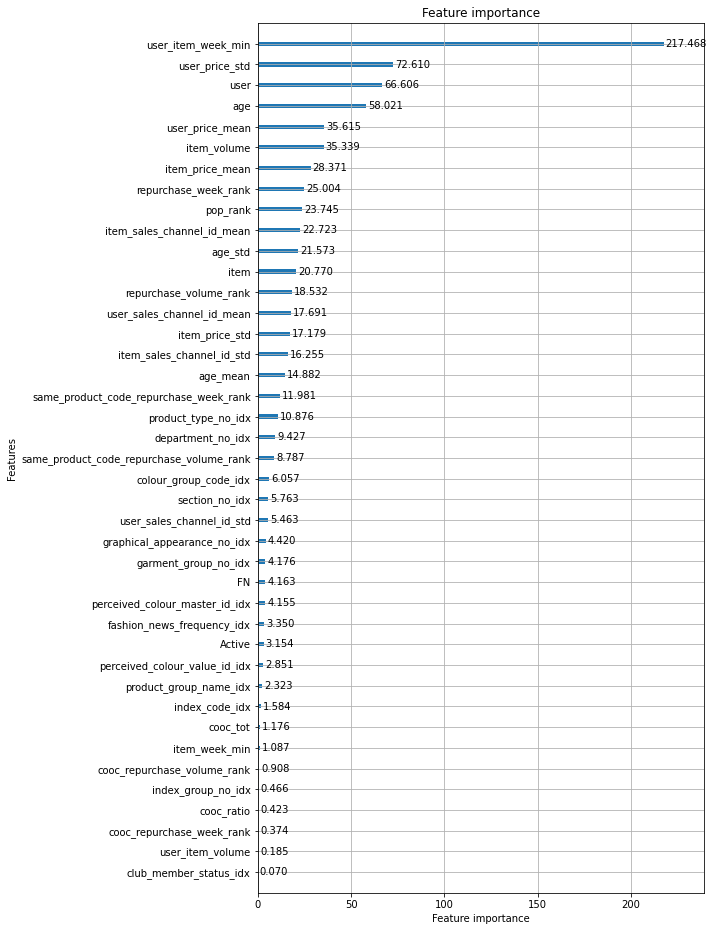

In [14]:
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))


In [15]:
valid_all['pred'] = model.predict(valid_all[feature_columns], num_iteration=model.best_iteration)
pred = valid_all.groupby(['user', 'item'])['pred'].max().reset_index()


In [16]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,7,"[84694, 84695, 54591, 85512, 78014, 85168, 844..."
1,17,"[54591, 2474, 45075, 84991, 85168, 84482, 3261..."
2,46,"[54591, 45075, 2474, 84991, 84483, 84482, 8551..."
3,76,"[33620, 45075, 85512, 84482, 85185, 33621, 849..."
4,93,"[2474, 54591, 45075, 84482, 85168, 85185, 8499..."
...,...,...
6858,137130,"[78014, 77998, 54591, 85186, 85185, 84482, 844..."
6859,137154,"[75578, 85350, 84993, 79326, 75565, 79327, 849..."
6860,137163,"[85168, 85512, 78014, 77998, 57707, 32619, 844..."
6861,137193,"[2474, 79760, 79762, 83788, 79761, 79763, 8378..."


In [17]:
gt = transactions.query("week == 1").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
merged = gt.merge(pred, on='user', how='left')
merged['item'] = merged['item'].fillna('').apply(list)
merged


,user,gt,item
0,7,[84694],"[84694, 84695, 54591, 85512, 78014, 85168, 844..."
1,17,"[36829, 78443]","[54591, 2474, 45075, 84991, 85168, 84482, 3261..."
2,46,"[54978, 74827, 64682, 84694]","[54591, 45075, 2474, 84991, 84483, 84482, 8551..."
3,76,[78876],"[33620, 45075, 85512, 84482, 85185, 33621, 849..."
4,93,"[67140, 65]","[2474, 54591, 45075, 84482, 85168, 85185, 8499..."
...,...,...,...
6858,137130,"[76898, 76898]","[78014, 77998, 54591, 85186, 85185, 84482, 844..."
6859,137154,"[79765, 80293]","[75578, 85350, 84993, 79326, 75565, 79327, 849..."
6860,137163,"[77982, 85608, 60208]","[85168, 85512, 78014, 77998, 57707, 32619, 844..."
6861,137193,"[85512, 85512, 85513, 85513, 82631, 85878]","[2474, 79760, 79762, 83788, 79761, 79763, 8378..."


In [18]:
mapk(merged['gt'], merged['item'])


0.02697768964010181

In [19]:
# assert False

submission

In [20]:
train, group_train = concat_train(datasets, 0, num_train_weeks)

[LightGBM] [Info] Total groups: 3810, total data: 301539
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013535 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4618
[LightGBM] [Info] Number of data points in the train set: 301539, number of used features: 41


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

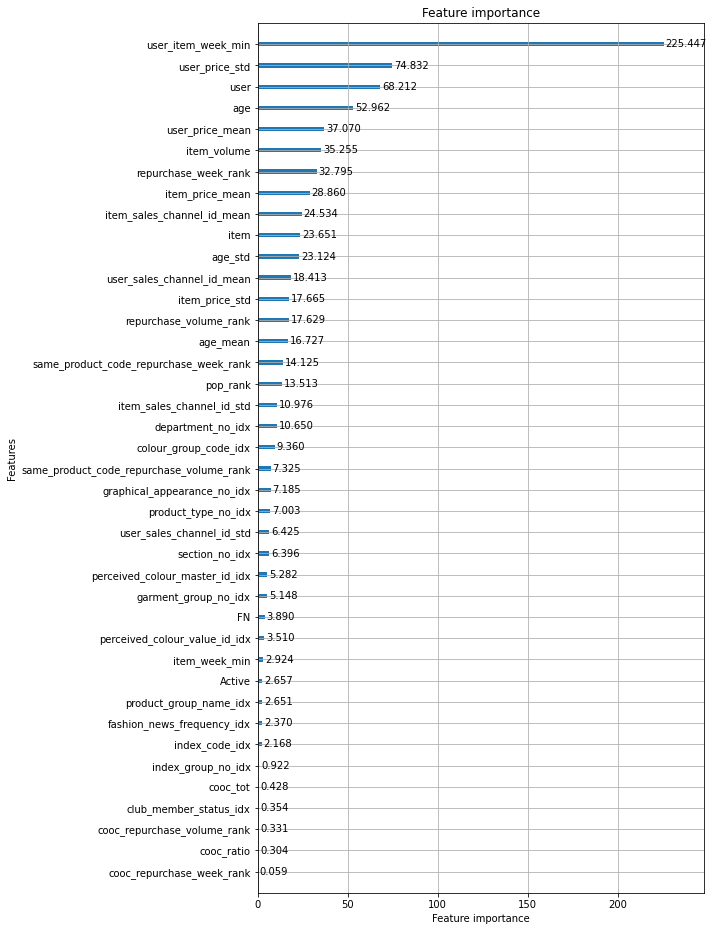

In [21]:
train_dataset = lgb.Dataset(train[feature_columns], train['y'], group=group_train)
best_iteration = model.best_iteration
model = lgb.train(params, train_dataset, num_boost_round=best_iteration)
lgb.plot_importance(model, importance_type='gain', figsize=(8, 16))

In [22]:
target_users = users['user'].values
target_users

array([     0,      1,      2, ..., 137195, 137196, 137197])

In [23]:
candidates = create_candidates(transactions, target_users, 1)

week: 1
duplicates: 1.033747426894387
            strategy   volume     ratio
0                pop  3292752  0.743570
1  same_product_code   573668  0.129546
2               cooc   470930  0.106346
3         repurchase    90949  0.020538


In [24]:
candidates = attach_features(transactions, users, items, candidates, 1)

week: 1


In [25]:
candidates['pred'] = model.predict(candidates[feature_columns])
pred = candidates.groupby(['user', 'item'])['pred'].max().reset_index()

In [26]:
pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()
pred


,user,item
0,0,"[85513, 77998, 82368, 84991, 85512, 84891, 326..."
1,1,"[85718, 54612, 32619, 85512, 85513, 77998, 840..."
2,2,"[85512, 85513, 84066, 54612, 77998, 85493, 326..."
3,3,"[85512, 85513, 84995, 77998, 84991, 84066, 326..."
4,4,"[85512, 54612, 77998, 84066, 32619, 85513, 545..."
...,...,...
137193,137193,"[82631, 85878, 85513, 85512, 82632, 82629, 826..."
137194,137194,"[67971, 67968, 67972, 67973, 85512, 85718, 855..."
137195,137195,"[85718, 77998, 82368, 85168, 85513, 85512, 786..."
137196,137196,"[82630, 82632, 82629, 82631, 85512, 85718, 855..."


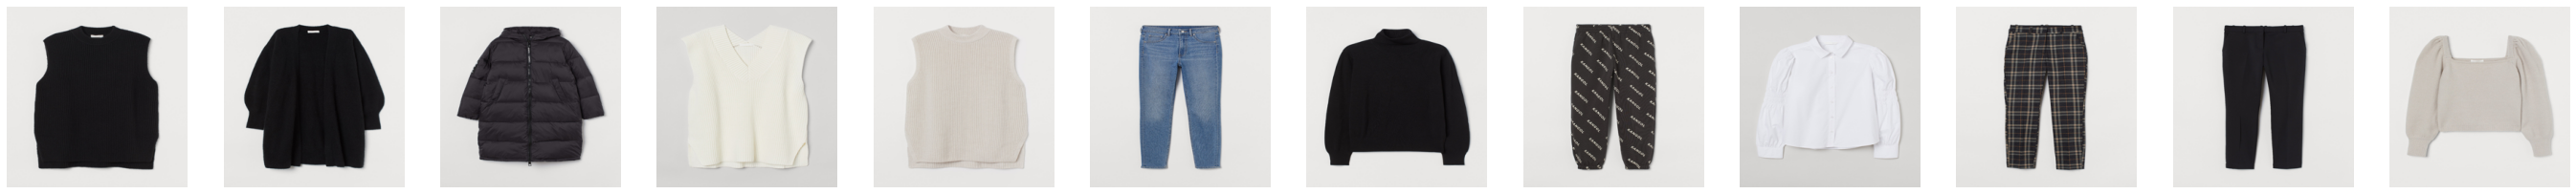

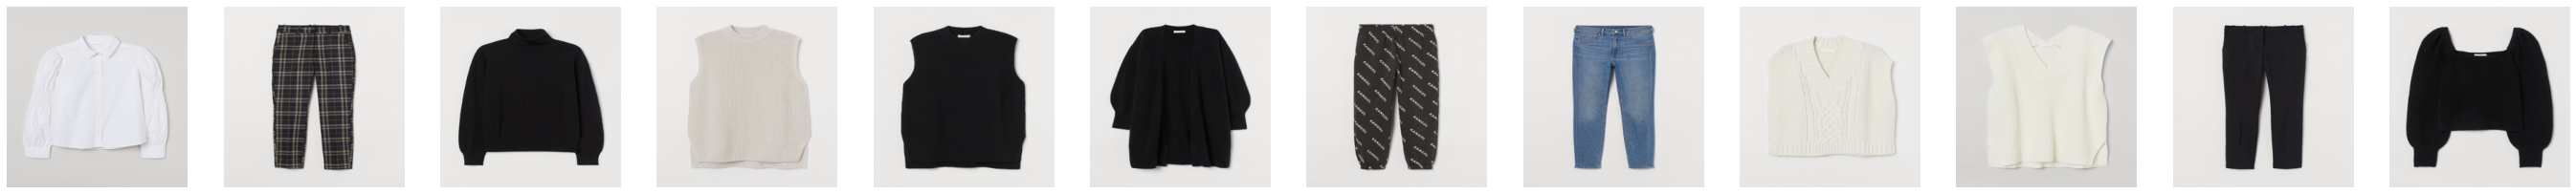

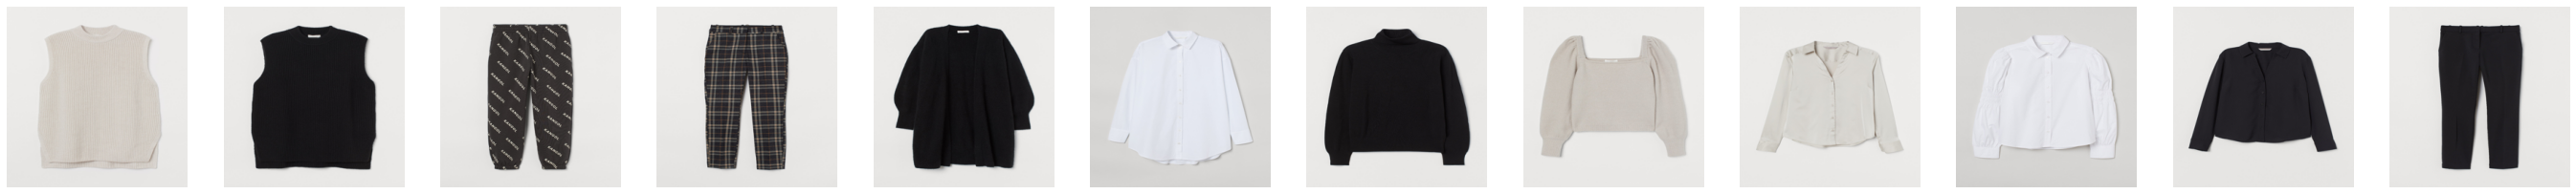

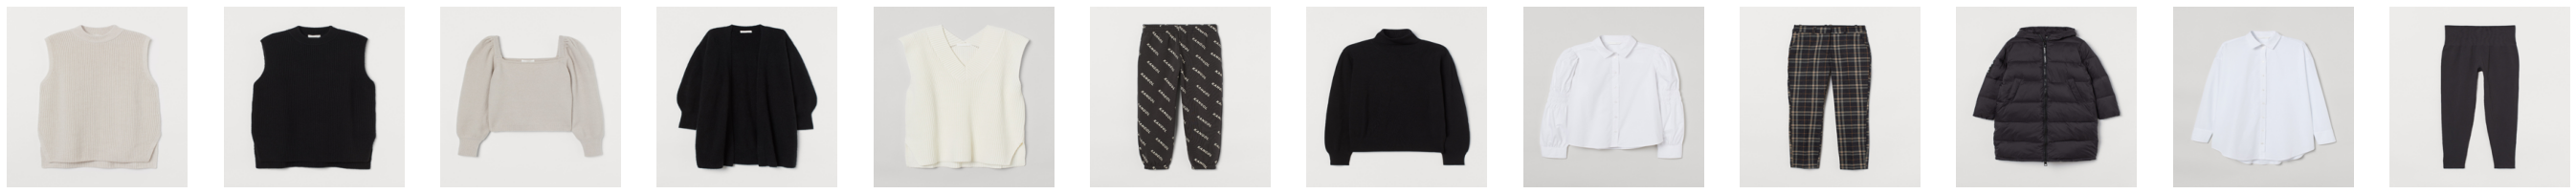

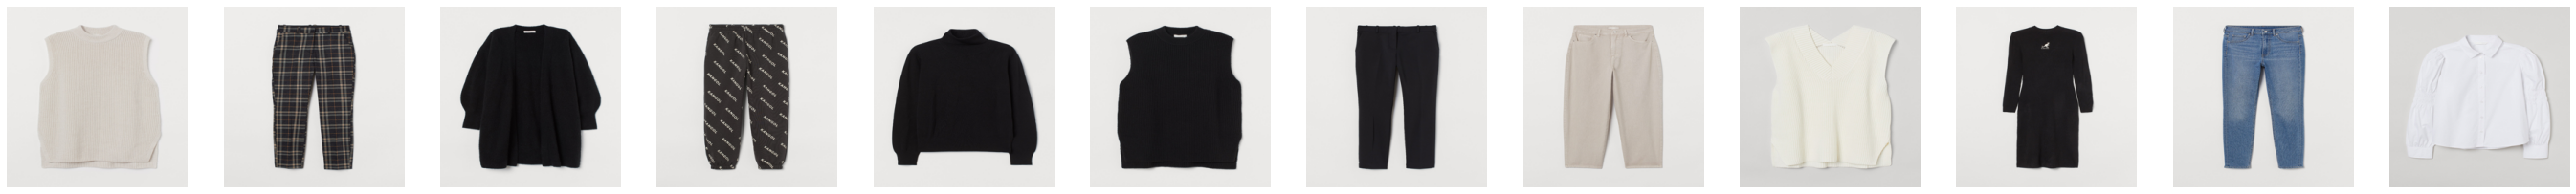

In [27]:
for i in range(5):
    plot_images(dataset, pred['item'][i])

In [28]:
mp_user = pd.read_pickle(f"input/{dataset}/mp_customer_id.pkl")
mp_item = pd.read_pickle(f"input/{dataset}/mp_article_id.pkl")

In [29]:
a_user = mp_user['val'].values
a_item = mp_item['val'].values

In [30]:
pred['customer_id'] = pred['user'].apply(lambda x: a_user[x])
pred['prediction'] = pred['item'].apply(lambda x: list(map(lambda y: a_item[y], x)))

In [31]:
pred['prediction'] = pred['prediction'].apply(lambda x: ' '.join(map(str, x)))

In [32]:
submission = pred[['customer_id', 'prediction']]
submission

,customer_id,prediction
0,7f1233293cc6ff19b226f60d66a8d11709947554223107...,0924243002 0863595006 0889550002 0915526001 09...
1,a52b6a1ce0003caa79cb85491606415f16efa502d046b9...,0928206001 0751471043 0673677002 0924243001 09...
2,b051873c9de518c2271755695d56c8c0cb96dcc969f363...,0924243001 0924243002 0904571001 0751471043 08...
3,28fc996fe679cb890b91010a6a4cd3ffd61d3846b24e0e...,0924243001 0924243002 0915529005 0863595006 09...
4,ca98b3ba46d78fc9cce3e411ebfe85c50610b6009ecb9d...,0924243001 0751471043 0863595006 0904571001 06...
...,...,...
137193,0a994cf9c074e6f77dea5a3fad098ac8e75b1e630d7a00...,0891591003 0933032002 0924243002 0924243001 08...
137194,69246fc388913a6ba01353e4ae21493e7e9610a8dca648...,0810169017 0810169002 0810169018 0810169020 09...
137195,b55e538e358cc2c00b78a926d438be22daa0f6847f4423...,0928206001 0863595006 0889550002 0918292001 09...
137196,37873090b5dcbaeed55d32a3033fb8f25ea281486efeb2...,0891591002 0891591007 0891591001 0891591003 09...


In [33]:
submission.to_csv('submission.csv', index=False)